In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.optimize import minimize

In [ ]:
def gaussian(eval_point, tab_point, radius=5, tab_scale=3):
    ex, ey = eval_point ; tx, ty = tab_point
    numerator = -((ex-tx)**2+(ey-ty)**2)
    denominator = tab_scale**2*radius**2
    return np.exp(numerator / denominator)

def iterate_points(eval_point, tab_points):
    vals = list(map(gaussian, [eval_point]*len(tab_points), tab_points))
    return max(vals)

def riemann_sum(room, tab_points: list):
    roomw, roomh = room.shape
    meshx = np.arange(0, roomw) ; meshy = np.arange(0, roomh)
    meshx, meshy = np.meshgrid(meshx, meshy)
    max_influence = np.zeros_like(meshx)
    tab_points.append((0, 25))
    for tabx, taby in tab_points:
        val = gaussian((meshx, meshy), (tabx, taby))
        max_influence = np.maximum(max_influence, val)
    return max_influence, np.sum(max_influence)

In [68]:
def visualize(max_influence: np.array, tab_points, tab_rad=5):
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(max_influence.T, origin='lower', cmap='viridis', aspect='equal')
    for tab_point in tab_points:
        tab_point = tab_point[::-1]
        circ = plt.Circle(tab_point, tab_rad, fill=False)
        ax.add_patch(circ)
    ax.set_xlabel('x (ft)')
    ax.set_ylabel('y (ft)')
    ax.set_title('Height Field (Top View)')
    
    plt.colorbar(im, ax=ax, label='h(x,y)')
    plt.show()

[[0.8007374  0.83341612 0.85975217 0.87907163 0.89087108 0.89483932
  0.89087108 0.87907163 0.85975217 0.83341612 0.8007374  0.76253177
  0.71972298 0.67330588 0.62430821 0.57375342 0.52262615 0.47184199
  0.42222277 0.374478   0.32919299 0.28682331 0.24769539 0.21201227
  0.19311982]
 [0.83341612 0.86742847 0.89483932 0.91494723 0.92722822 0.9313584
  0.92722822 0.91494723 0.89483932 0.86742847 0.83341612 0.79365128
  0.74909543 0.70078401 0.64978671 0.59716874 0.54395493 0.49109823
  0.439454   0.38976074 0.34262761 0.29852879 0.25780403 0.24117747
  0.22362656]
 [0.85975217 0.89483932 0.92311635 0.94385967 0.95652874 0.96078944
  0.95652874 0.94385967 0.92311635 0.89483932 0.85975217 0.81873075
  0.77276694 0.72292887 0.67032005 0.61603935 0.56114397 0.50661699
  0.4533408  0.40207722 0.35345468 0.31348618 0.29588696 0.27680432
  0.25666078]
 [0.87907163 0.91494723 0.94385967 0.96506912 0.97802287 0.98237931
  0.97802287 0.96506912 0.94385967 0.91494723 0.87907163 0.83712843
  0.790

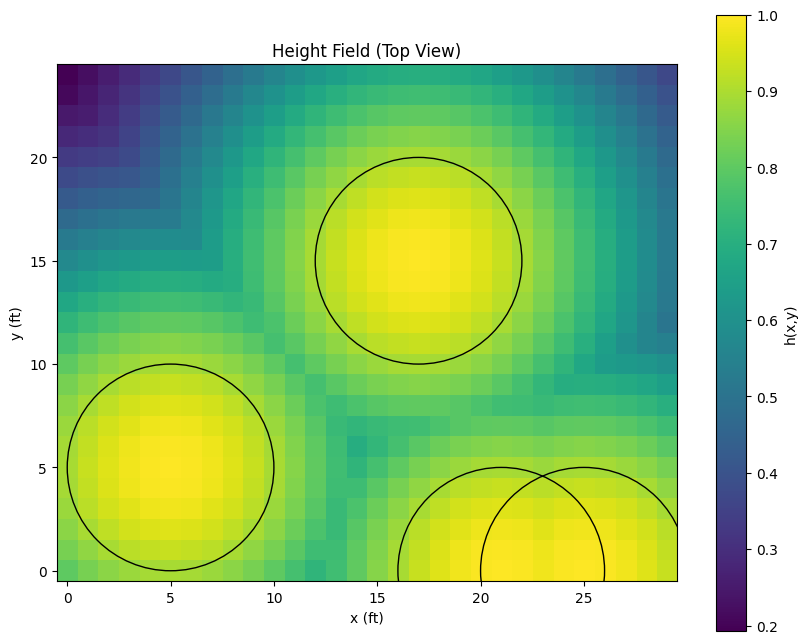

In [69]:
room = np.zeros((25, 30))
tab_points = [(5, 5), (0, 21), (15, 17)]
room, integral = riemann_sum(room, tab_points)
print(room)
print(f'Integral: {integral}')
visualize(room, tab_points)

In [70]:
def objective_function(p, room_size, radius, tab_scale):
    """
    p: flat array [x1, y1, x2, y2, x3, y3, x4, y4]
    """
    n_tables = len(p) // 2
    tab_points = [(p[2*i], p[2*i+1]) for i in range(n_tables)]
    room = np.zeros(room_size)
    max_influence, integral = riemann_sum(room, tab_points)
    
    # Return NEGATIVE because we want to maximize but scipy minimizes
    return -integral


def constraint_no_overlap(p, radius):
    """
    Constraint function: returns positive when constraint is satisfied.
    We need all pairs of tables to be at least 2*radius apart.
    """
    n_tables = len(p) // 2
    
    # Find minimum distance between any pair
    min_dist = float('inf')
    for i in range(n_tables):
        for j in range(i+1, n_tables):
            x1, y1 = p[2*i], p[2*i+1]
            x2, y2 = p[2*j], p[2*j+1]
            dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            min_dist = min(min_dist, dist)
    
    # Return positive when valid (dist >= 2*radius)
    return min_dist - 2*radius


def optimize_tables(room_size, n_tables=4, radius=2.5, tab_scale=3):
    """
    Find optimal table positions using scipy.optimize.
    """
    W, H = room_size
    
    # Initial guess - evenly spaced grid
    initial = []
    if n_tables == 4:
        # 2x2 grid
        initial = [
            W/3, H/3,      # Table 1
            2*W/3, H/3,    # Table 2
            W/3, 2*H/3,    # Table 3
            2*W/3, 2*H/3   # Table 4
        ]
    else:
        # Generic: spread them out
        for i in range(n_tables):
            x = (i % 2 + 1) * W / 3
            y = (i // 2 + 1) * H / 3
            initial.extend([x, y])
    
    initial = np.array(initial)
    
    # Bounds: each table must stay in room
    bounds = []
    for i in range(n_tables):
        bounds.append((radius, W - radius))  # x bounds
        bounds.append((radius, H - radius))  # y bounds
    
    # Constraint: no overlaps
    constraints = {
        'type': 'ineq',  # inequality constraint (>= 0)
        'fun': constraint_no_overlap,
        'args': (radius,)
    }
    
    print("Starting optimization...")
    print(f"Initial positions: {[(initial[2*i], initial[2*i+1]) for i in range(n_tables)]}")
    
    # Run optimization
    result = minimize(
        objective_function,
        initial,
        args=(room_size, radius, tab_scale),
        method='SLSQP',  # Sequential Least Squares Programming (handles constraints)
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 100, 'disp': True, 'ftol': 1e-6}
    )
    
    # Extract results
    optimal_positions = [(result.x[2*i], result.x[2*i+1]) for i in range(n_tables)]
    optimal_integral = -result.fun  # Negate back
    
    print("\n" + "="*60)
    print("OPTIMIZATION COMPLETE")
    print("="*60)
    print(f"Success: {result.success}")
    print(f"Message: {result.message}")
    print(f"Iterations: {result.nit}")
    print(f"\nOptimal positions:")
    for i, (x, y) in enumerate(optimal_positions):
        print(f"  Table {i+1}: ({x:.2f}, {y:.2f})")
    print(f"\nOptimal integral: {optimal_integral:.4f}")
    
    return optimal_positions, optimal_integral, result

Starting optimization...
Initial positions: [(np.float64(6.666666666666667), np.float64(8.333333333333334)), (np.float64(13.333333333333334), np.float64(8.333333333333334)), (np.float64(6.666666666666667), np.float64(16.666666666666668)), (np.float64(13.333333333333334), np.float64(16.666666666666668))]
Optimization terminated successfully    (Exit mode 0)
            Current function value: -458.2957038814582
            Iterations: 17
            Function evaluations: 157
            Gradient evaluations: 17

OPTIMIZATION COMPLETE
Success: True
Message: Optimization terminated successfully
Iterations: 17

Optimal positions:
  Table 1: (4.71, 4.39)
  Table 2: (14.74, 6.01)
  Table 3: (4.96, 14.84)
  Table 4: (14.18, 18.92)

Optimal integral: 458.2957


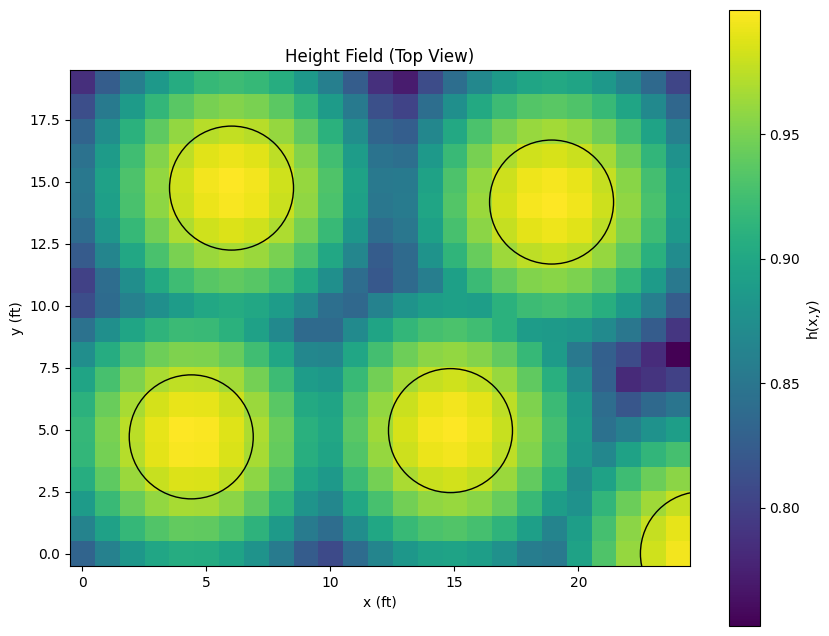


Comparing with initial configuration:
Initial integral: 435.8509
Optimized integral: 458.2957
Improvement: 5.1%


In [71]:
room_size = (20, 25)
optimal_positions, max_integral, result = optimize_tables(
    room_size, 
    n_tables=4, 
    radius=2.5, 
    tab_scale=3
)

# Visualize the result
room = np.zeros(room_size)
max_influence, integral = riemann_sum(room, optimal_positions)
visualize(max_influence, optimal_positions, tab_rad=2.5)

# Compare with initial guess
print("\nComparing with initial configuration:")
initial_config = [(7, 7), (18, 7), (7, 13), (18, 13)]
room_init = np.zeros(room_size)
_, initial_integral = riemann_sum(room_init, initial_config)
print(f"Initial integral: {initial_integral:.4f}")
print(f"Optimized integral: {max_integral:.4f}")
print(f"Improvement: {((max_integral - initial_integral)/initial_integral * 100):.1f}%")